In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
import matplotlib.dates as mdates

### Migration labelling

Migration labelling will be based on the total movement of the previous five days - if at one point this amount increases 500km then the migration has started and all the following rows (also the previous five) will be labelled up until the sum of the previous five days falls below 100km. From this point on no labels are set to timestamps. The choice between either winter migration ('W') or summer migration ('S') will be made based on the latitude change (which needs to be constantly changing in the right direction in order to count the migration started).

In [16]:
data_migration_labels = pd.read_csv('data/stork_tracking_1perday_filter.csv')

data_migration_labels['timestamp'] = pd.to_datetime(data_migration_labels['timestamp'])

#Set timestamp as the index
data_migration_labels.set_index('timestamp', inplace=True)

In [17]:
# Sort the DataFrame by 'individual_id' and 'date'
data_migration_labels.sort_values(by=['timestamp', 'id_year'], inplace=True)

data_migration_labels['sum_last_five'] = np.nan

data_migration_labels['migration'] = np.nan

data_migration_labels.head()

,event-id,location-long,location-lat,ground-speed,heading,tag-local-identifier,individual-local-identifier,altitude,year,id_year,distance_from_last,sum_last_five,migration
timestamp,,,,,,,,,,,,,
1994-08-06 20:26:07,155871929,12.111,52.089,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,0.000000,NaN,NaN
1994-08-07 20:02:55,155871943,12.042,52.119,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,5.787470,NaN,NaN
1994-08-08 19:39:13,155871957,12.138,52.120,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,6.576460,NaN,NaN
1994-08-09 19:18:43,155871973,12.241,52.121,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,7.055703,NaN,NaN
1994-08-10 18:57:55,155871987,12.019,52.137,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,15.306537,NaN,NaN


In [18]:
def calculate_last_three_sum(group):
    group['sum_last_five'] = group['distance_from_last'].rolling(window=5, min_periods=1).sum()
    return group

# Apply the function to each individual's group
data_migration_labels = data_migration_labels.groupby('id_year').apply(calculate_last_three_sum)

data_migration_labels = data_migration_labels.reset_index(level='id_year', drop=True)

data_migration_labels.sort_values(by=['timestamp', 'id_year'], inplace=True)

In [19]:
data_migration_labels.head()

,event-id,location-long,location-lat,ground-speed,heading,tag-local-identifier,individual-local-identifier,altitude,year,id_year,distance_from_last,sum_last_five,migration
timestamp,,,,,,,,,,,,,
1994-08-06 20:26:07,155871929,12.111,52.089,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,0.000000,0.000000,NaN
1994-08-07 20:02:55,155871943,12.042,52.119,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,5.787470,5.787470,NaN
1994-08-08 19:39:13,155871957,12.138,52.120,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,6.576460,12.363930,NaN
1994-08-09 19:18:43,155871973,12.241,52.121,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,7.055703,19.419633,NaN
1994-08-10 18:57:55,155871987,12.019,52.137,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,15.306537,34.726171,NaN


Let us visualise the sum of past three days distribution for random individuals to get a better understanding of the temporal patterns.

In [20]:
data_migration_no_year = data_migration_labels.copy()

data_migration_no_year['date'] = data_migration_no_year.index

data_migration_no_year['date'] = pd.to_datetime(data_migration_no_year['date'])

data_migration_no_year['month'] = data_migration_no_year['date'].dt.month
data_migration_no_year['day'] = data_migration_no_year['date'].dt.dayofyear

#Remove the year component from the timestamp
#data_migration_no_year['date'] = data_migration_no_year['date'].dt.strftime('%m-%d')

In [21]:
data_migration_no_year.head()

,event-id,location-long,location-lat,ground-speed,heading,tag-local-identifier,individual-local-identifier,altitude,year,id_year,distance_from_last,sum_last_five,migration,date,month,day
timestamp,,,,,,,,,,,,,,,,
1994-08-06 20:26:07,155871929,12.111,52.089,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,0.000000,0.000000,NaN,1994-08-06 20:26:07,8,218
1994-08-07 20:02:55,155871943,12.042,52.119,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,5.787470,5.787470,NaN,1994-08-07 20:02:55,8,219
1994-08-08 19:39:13,155871957,12.138,52.120,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,6.576460,12.363930,NaN,1994-08-08 19:39:13,8,220
1994-08-09 19:18:43,155871973,12.241,52.121,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,7.055703,19.419633,NaN,1994-08-09 19:18:43,8,221
1994-08-10 18:57:55,155871987,12.019,52.137,NaN,NaN,14555,14555E,0.0,1994,14555E_1994,15.306537,34.726171,NaN,1994-08-10 18:57:55,8,222


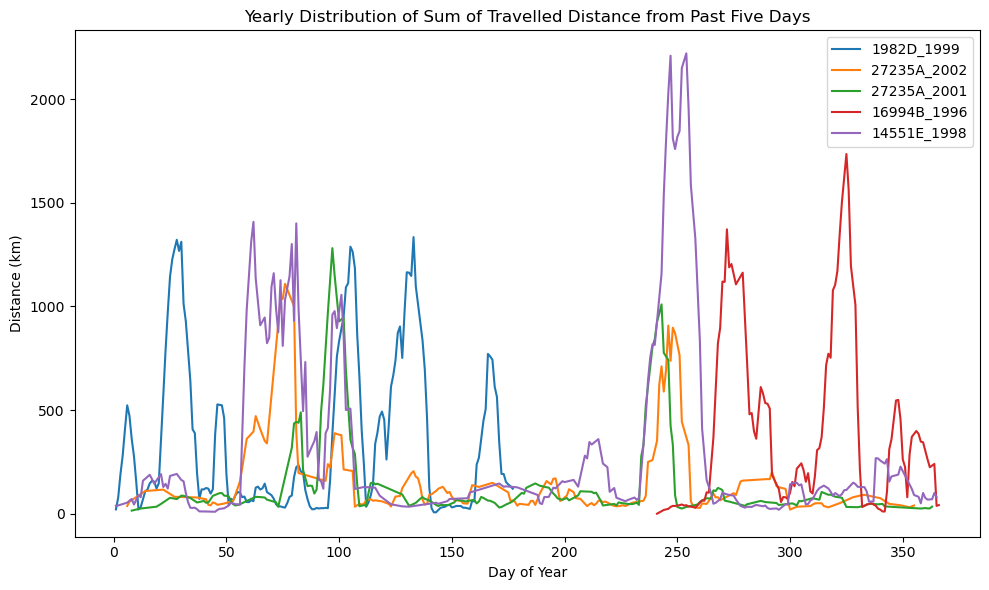

In [22]:
#Pick three random individuals from the list
selected_individuals = np.random.choice(data_migration_no_year['id_year'].unique(), 5, replace=False)

filtered_df = data_migration_no_year[data_migration_no_year['id_year'].isin(selected_individuals)]


#Plot the yearly distribution for each individual
plt.figure(figsize=(10, 6))

for individual in selected_individuals:
    
    individual_data = filtered_df[filtered_df['id_year'] == individual]
    
    plt.plot(individual_data['day'], individual_data['sum_last_five'], label=individual)

plt.xlabel('Day of Year')
plt.ylabel('Distance (km)')
plt.title('Yearly Distribution of Sum of Travelled Distance from Past Five Days')
plt.legend()

plt.tight_layout()

Plots show that migration usually happens in phases and there are short periods of little movement in between sections with loads of movement.

Let's try the first version of migration labelling.

In [29]:
data_one_per_day_filter = pd.read_csv('data/stork_tracking_1perday_filter.csv')

data_one_per_day_filter['timestamp'] = pd.to_datetime(data_one_per_day_filter['timestamp'])

#Set timestamp as the index
data_one_per_day_filter.set_index('timestamp', inplace=True)

In [23]:
def label_migration(df):
    df = df.reset_index()
    
    # Sort by timestamp to ensure chronological order
    df.sort_values('timestamp', inplace=True)

    # Calculate the change in latitude
    df['latitude_change'] = df['location-lat'].diff()

    # Calculate the rolling sum of distance_from_last over the past 5 days
    df['rolling_sum_5_days'] = df['distance_from_last'].rolling(window=5, min_periods=1).sum()
    
    df['migration'] = np.nan

    migration_active = False
    migration_type = None

    for i in range(len(df)):
        
        # Ensure we have at least 5 records to look back on
        if i >= 4:
            # Check if rolling sum exceeds 500 km for the past 5 entries
            if df.iloc[i]['rolling_sum_5_days'] > 500:
                last_five_lat_changes = df.iloc[i-4:i+1]['latitude_change']
                
                # Starting condition for migration
                if all(last_five_lat_changes < 0):
                    df.loc[i-4:i+1, 'migration'] = 'W'  #Winter migration
                    migration_active = True
                    migration_type = 'W'
                elif all(last_five_lat_changes > 0):
                    df.loc[i-4:i+1, 'migration'] = 'S'  #Summer migration
                    migration_active = True
                    migration_type = 'S'

            #Continue the current migration type if migration is active and the rolling sum is still above 100 km
            elif migration_active and df.iloc[i]['rolling_sum_5_days'] > 100:
                df.at[i, 'migration'] = migration_type
            else:
                #Reset migration status if rolling sum falls below 100 km
                migration_active = False
                migration_type = None

    #Drop the additional index from reset_index if it exists
    if 'index' in df.columns:
        df.drop('index', axis=1, inplace=True)
    
    return df

In [31]:
warnings.filterwarnings("ignore")

individual_labelled_data = data_one_per_day_filter.groupby('id_year').apply(label_migration).reset_index(drop=True)

individual_labelled_data.head(10)

,timestamp,event-id,location-long,location-lat,ground-speed,heading,tag-local-identifier,individual-local-identifier,altitude,year,id_year,distance_from_last,latitude_change,rolling_sum_5_days,migration
0,2001-05-25 21:44:15,155977183,12.050,52.095,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,0.000000,NaN,0.000000,NaN
1,2001-05-26 17:00:28,155977205,12.090,52.120,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,3.904943,0.025,3.904943,NaN
2,2001-05-27 07:31:25,155977222,12.090,52.082,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,4.228232,-0.038,8.133176,NaN
3,2001-07-19 16:53:17,155977247,20.785,55.085,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,665.140144,3.003,673.273320,NaN
4,2001-08-05 14:59:02,155977271,49.973,53.253,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,11.655827,-1.832,684.929147,W
5,2001-08-06 03:20:18,155977273,49.917,53.198,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,7.173177,-0.055,692.102324,W
6,2001-08-07 22:26:32,155977307,51.242,50.760,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,286.125064,-2.438,974.322444,W
7,2001-08-08 15:29:27,155977323,51.710,48.555,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,247.561034,-2.205,1217.655246,W
8,2001-08-09 16:38:29,155977339,51.699,46.942,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,179.343982,-1.613,731.859084,W
9,2001-08-10 18:04:08,155977357,55.239,45.481,NaN,NaN,13015,13015A,0.0,2001,13015A_2001,317.753359,-1.461,1037.956615,W


In [32]:
individual_labelled_data['day_of_year'] = individual_labelled_data['timestamp'].dt.dayofyear

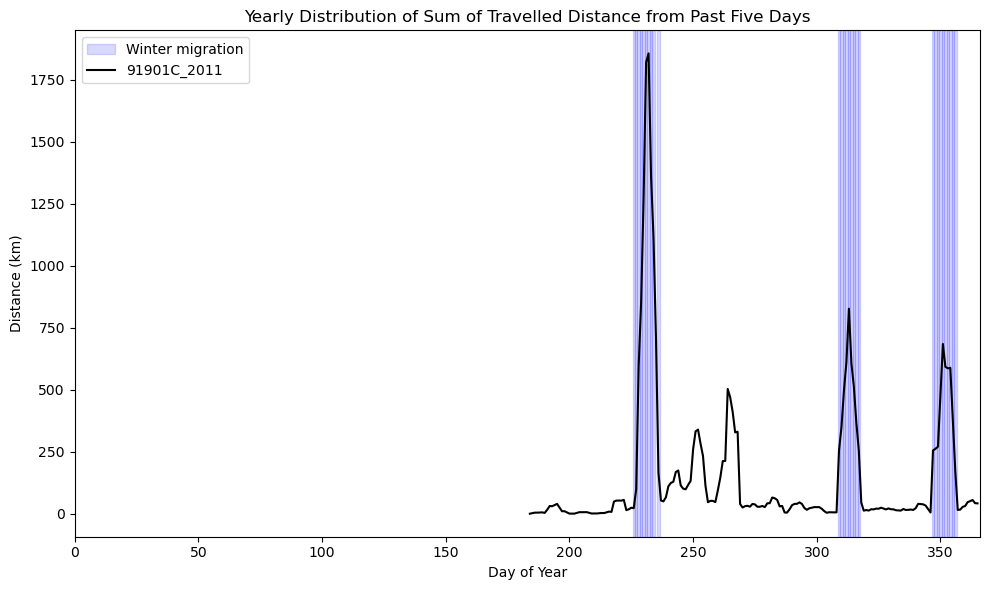

In [33]:
#Pick a random individual from the list
selected_individual = np.random.choice(individual_labelled_data['id_year'].unique(), 1, replace=False)

filtered_df = individual_labelled_data[individual_labelled_data['id_year'].isin(selected_individual)]

individual_data = filtered_df.copy()

plt.figure(figsize=(10, 6))

#Add background color for migration labels with unique labels
handles, labels = [], []
for i, row in individual_data.iterrows():
    if row['migration'] == 'W':
        plt.axvspan(row['day_of_year']-0.5, row['day_of_year']+0.5, color='blue', alpha=0.15, label='Winter migration')
        labels.append('Winter migration')
    elif row['migration'] == 'S':
        plt.axvspan(row['day_of_year']-0.5, row['day_of_year']+0.5, color='yellow', alpha=0.35, label='Summer migration')
        labels.append('Summer migration')

# Plot the rolling_sum_5_days
plt.plot(individual_data['day_of_year'], individual_data['rolling_sum_5_days'], label=selected_individual[0], c = 'black')
plt.xlim(0,366)

plt.xlabel('Day of Year')
plt.ylabel('Distance (km)')
plt.title('Yearly Distribution of Sum of Travelled Distance from Past Five Days')

#Ensure only one instance of each label is in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()

plt.show()

The plots show that there are some gaps in the labelled areas. The following function will try to fill those gaps.

In [34]:
def fill_migration_gaps(df):
    df = df.sort_values('day_of_year')

    # Identify the rows that have a migration label
    labelled_rows = df.dropna(subset=['migration'])

    for i, row in labelled_rows.iterrows():
        
        # Look ahead to find the next labelled row
        next_label_index = labelled_rows.index[labelled_rows.index > i].min()
        
        #If the gap to the next label is less than a month, fill it
        if pd.notna(next_label_index) and (row['day_of_year'] + 30) >= labelled_rows.at[next_label_index, 'day_of_year']:
            df.loc[i:next_label_index, 'migration'] = row['migration']

    return df

In [35]:
filled_individual_labelled_data = individual_labelled_data.groupby('id_year').apply(fill_migration_gaps).reset_index(drop=True)

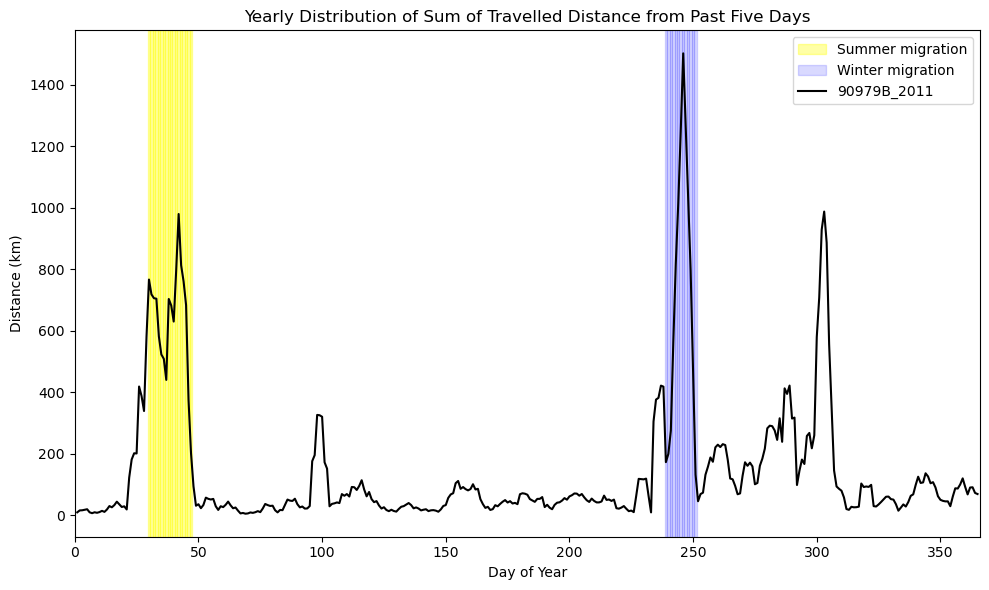

In [36]:
#Pick a random individual from the list
#selected_individual = ["Prinzesschen_2003"]
selected_individual = np.random.choice(filled_individual_labelled_data['id_year'].unique(), 1, replace=False)

filtered_df = filled_individual_labelled_data[filled_individual_labelled_data['id_year'].isin(selected_individual)]

individual_data = filtered_df.copy()

plt.figure(figsize=(10, 6))

#Add background color for migration labels with unique labels
handles, labels = [], []
for i, row in individual_data.iterrows():
    if row['migration'] == 'W':
        plt.axvspan(row['day_of_year']-0.5, row['day_of_year']+0.5, color='blue', alpha=0.15, label='Winter migration')
        labels.append('Winter migration')
    elif row['migration'] == 'S':
        plt.axvspan(row['day_of_year']-0.5, row['day_of_year']+0.5, color='yellow', alpha=0.35, label='Summer migration')
        labels.append('Summer migration')

# Plot the rolling_sum_5_days
plt.plot(individual_data['day_of_year'], individual_data['rolling_sum_5_days'], label=selected_individual[0], c = 'black')
plt.xlim(0,366)

plt.xlabel('Day of Year')
plt.ylabel('Distance (km)')
plt.title('Yearly Distribution of Sum of Travelled Distance from Past Five Days')

#Ensure only one instance of each label is in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()

plt.show()

"14551E_1997", "Prinzesschen_2004", 

In [57]:
#filled_individual_labelled_data.to_csv('data/migration.csv')

#### Migration statistics

The further analysis is done with a purpose to filter out odd cases not suitable for analysis.

In [37]:
migration_overview = pd.DataFrame({'id_year' : filled_individual_labelled_data['id_year'].unique()})

Counting the days for summer migration per individual.

In [38]:
def sum_migration_days(df, migration_label):
    """
    Calculate the total duration of labeled migration periods for a given migration label ('S' or 'W').

    Args:
    df (DataFrame): The DataFrame containing migration data.
    migration_label (str): The migration label ('S' or 'W') to filter by.

    Returns:
    DataFrame: A DataFrame with 'id_year' and the total duration of labeled migration periods.
    """
    # Filter data for the given migration label
    migration_data = df[df['migration'] == migration_label]

    # Sort data by 'id_year' and 'timestamp'
    migration_data.sort_values(['id_year', 'timestamp'], inplace=True)

    # Identify the start and end of contiguous migration periods
    migration_data['new_period'] = (migration_data['id_year'] != migration_data['id_year'].shift(1)) | \
                                   (migration_data['timestamp'].diff().dt.days > 1)

    # Calculate the length of each period
    migration_data['next_timestamp'] = migration_data['timestamp'].shift(-1)
    migration_data.loc[migration_data['new_period'].shift(-1).fillna(True), 'next_timestamp'] = migration_data['timestamp']
    migration_data['period_length'] = (migration_data['next_timestamp'] - migration_data['timestamp']).dt.days + 1

    # Sum the lengths of periods for each 'id_year'
    total_migration_period = migration_data.groupby('id_year')['period_length'].sum().reset_index()
    total_migration_period.columns = ['id_year', f'{migration_label}_total_period']

    return total_migration_period

In [39]:
# Applying this function to count the total 'S' migration days
s_migration_days = sum_migration_days(filled_individual_labelled_data, 'S')
migration_overview = migration_overview.merge(s_migration_days, on='id_year', how='left').fillna(0)

In [40]:
# Applying this function to count the total 'W' migration days
w_migration_days = sum_migration_days(filled_individual_labelled_data, 'W')
migration_overview = migration_overview.merge(w_migration_days, on='id_year', how='left').fillna(0)

Adding columns about the first and last occurance day of 'S' and 'W' labels.

In [41]:
s_migration_data = filled_individual_labelled_data[filled_individual_labelled_data['migration'] == 'S']

s_migration_start = s_migration_data.groupby('id_year')['day_of_year'].first().reset_index()
s_migration_end = s_migration_data.groupby('id_year')['day_of_year'].last().reset_index()

s_migration_start.columns = ['id_year', 'first_S']
s_migration_end.columns = ['id_year', 'last_S']

In [42]:
w_migration_data = filled_individual_labelled_data[filled_individual_labelled_data['migration'] == 'W']

w_migration_start = w_migration_data.groupby('id_year')['day_of_year'].first().reset_index()
w_migration_end = w_migration_data.groupby('id_year')['day_of_year'].last().reset_index()

w_migration_start.columns = ['id_year', 'first_W']
w_migration_end.columns = ['id_year', 'last_W']

In [43]:
migration_overview = migration_overview.merge(s_migration_start, on='id_year', how='left').fillna(-1)
migration_overview = migration_overview.merge(s_migration_end, on='id_year', how='left').fillna(-1)

migration_overview = migration_overview.merge(w_migration_start, on='id_year', how='left').fillna(-1)
migration_overview = migration_overview.merge(w_migration_end, on='id_year', how='left').fillna(-1)

Now let us also calculate the length for shortest migration windows.

In [44]:
def shortest_window_length(df, migration_label):
    """
    Calculate the shortest window length for the given migration label ('S' or 'W').

    Args:
    df (DataFrame): The DataFrame containing migration data.
    migration_label (str): The migration label ('S' or 'W') to filter by.

    Returns:
    DataFrame: A DataFrame with 'id_year' and the shortest window length for the given migration type.
    """
    filtered_data = df.copy()

    # Identify the start and end of each migration window
    filtered_data['window_start'] = ((filtered_data['migration'] == migration_label) & 
                                     (filtered_data['migration'].shift(1) != migration_label))
    
    filtered_data['window_end'] = ((filtered_data['migration'] == migration_label) & 
                                   (filtered_data['migration'].shift(-1) != migration_label))

    # Calculate window length
    window_start_end = filtered_data[filtered_data['window_start'] | filtered_data['window_end']]
    window_lengths = window_start_end.groupby('id_year')['timestamp'].diff().dt.days.shift(-1).dropna()

    # Find the shortest window length for each 'id_year'
    shortest_window = window_lengths.groupby(window_start_end['id_year']).min().reset_index()
    shortest_window.columns = ['id_year', f'shortest_{migration_label}_window']

    return shortest_window

In [45]:
# Calculate the shortest window lengths for 'S' and 'W' migrations
shortest_s_window = shortest_window_length(filled_individual_labelled_data, 'S')
shortest_w_window = shortest_window_length(filled_individual_labelled_data, 'W')

# Merge these with the migration_overview DataFrame
migration_overview = migration_overview.merge(shortest_s_window, on='id_year', how='left').fillna(-1)
migration_overview = migration_overview.merge(shortest_w_window, on='id_year', how='left').fillna(-1)

Adding columns about the number of migration chuncks, both for summer and winter migration.

In [46]:
def count_migration_windows(df, migration_label):
    """
    Count the number of migration windows for a given migration label ('S' or 'W'),
    where a window is a continuous block of migration.

    Args:
    df (DataFrame): The DataFrame containing migration data.
    migration_label (str): The migration label ('S' or 'W') to filter by.

    Returns:
    DataFrame: A DataFrame with 'id_year' and the count of migration windows.
    """
    filtered_data = df.copy()

    # Identify the start of each new migration window
    filtered_data['new_window'] = ((filtered_data['migration'] == migration_label) & 
                                   (filtered_data['migration'].shift(1) != migration_label))

    # Count the number of new windows for each 'id_year'
    window_counts = filtered_data.groupby('id_year')['new_window'].sum().reset_index()
    window_counts.columns = ['id_year', f'{migration_label}_windows']

    return window_counts

In [47]:
#Applying the function to count 'S' and 'W' migration phases
s_migration_phases = count_migration_windows(filled_individual_labelled_data, 'S')
w_migration_phases = count_migration_windows(filled_individual_labelled_data, 'W')

#Merge these counts with the migration_overview DataFrame
migration_overview = migration_overview.merge(s_migration_phases, on='id_year', how='left').fillna(0)
migration_overview = migration_overview.merge(w_migration_phases, on='id_year', how='left').fillna(0)

Last variable to add is the check of summer and winter migration order. Ideally summer migration should always come before winter migration in the year.

In [48]:
def check_migration_order(df):
    """
    Check the order of 'S' and 'W' migration labels for each individual.

    Args:
    df (DataFrame): The DataFrame containing migration data.

    Returns:
    DataFrame: A DataFrame with individual identifiers and a value indicating the first migration label (1 for 'S', 0 for 'W', -1 if neither is present).
    """
    # Ensure the data is sorted by individual and timestamp
    df_sorted = df.sort_values(['id_year', 'timestamp'])

    # Define a function to determine the first label
    def first_label(group):
        filtered_group = group[group['migration'].isin(['S', 'W'])]
        if not filtered_group.empty:
            first_label = filtered_group['migration'].iloc[0]
            return 1 if first_label == 'S' else 0
        else:
            return -1  # Return -1 or some other indicator if no 'S' or 'W' labels are present

    # Apply the function to each group
    order_df = df_sorted.groupby('id_year').apply(first_label).reset_index()
    order_df.columns = ['id_year', 'S_before_W']

    return order_df

In [49]:
migration_orders = check_migration_order(filled_individual_labelled_data)

migration_overview = migration_overview.merge(migration_orders, on='id_year', how='left')

In [51]:
migration_overview.head()

,id_year,S_total_period,W_total_period,first_S,last_S,first_W,last_W,shortest_S_window,shortest_W_window,S_windows,W_windows,S_before_W
0,13015A_2001,0.0,26.0,-1.0,-1.0,217.0,238.0,-1.0,20.0,0,1,0
1,14542E_1999,11.0,30.0,246.0,254.0,222.0,245.0,7.0,23.0,1,1,0
2,14542E_2000,7.0,0.0,262.0,271.0,-1.0,-1.0,8.0,-1.0,1,0,1
3,14542E_2001,27.0,15.0,96.0,132.0,242.0,288.0,35.0,45.0,1,1,1
4,14542E_2002,0.0,34.0,-1.0,-1.0,247.0,278.0,-1.0,30.0,0,1,0


In [52]:
migration_overview.tail()

,id_year,S_total_period,W_total_period,first_S,last_S,first_W,last_W,shortest_S_window,shortest_W_window,S_windows,W_windows,S_before_W
131,Prinzesschen_2002,74.0,110.0,50.0,125.0,9.0,346.0,74.0,9.0,1,3,0
132,Prinzesschen_2003,101.0,107.0,60.0,158.0,229.0,365.0,98.0,29.0,1,2,1
133,Prinzesschen_2004,58.0,202.0,67.0,164.0,26.0,366.0,96.0,38.0,1,3,0
134,Prinzesschen_2005,100.0,77.0,55.0,120.0,237.0,362.0,64.0,20.0,1,2,1
135,Prinzesschen_2006,71.0,131.0,61.0,115.0,235.0,356.0,53.0,22.0,1,2,1


#### Filtering out "high quality" individuals

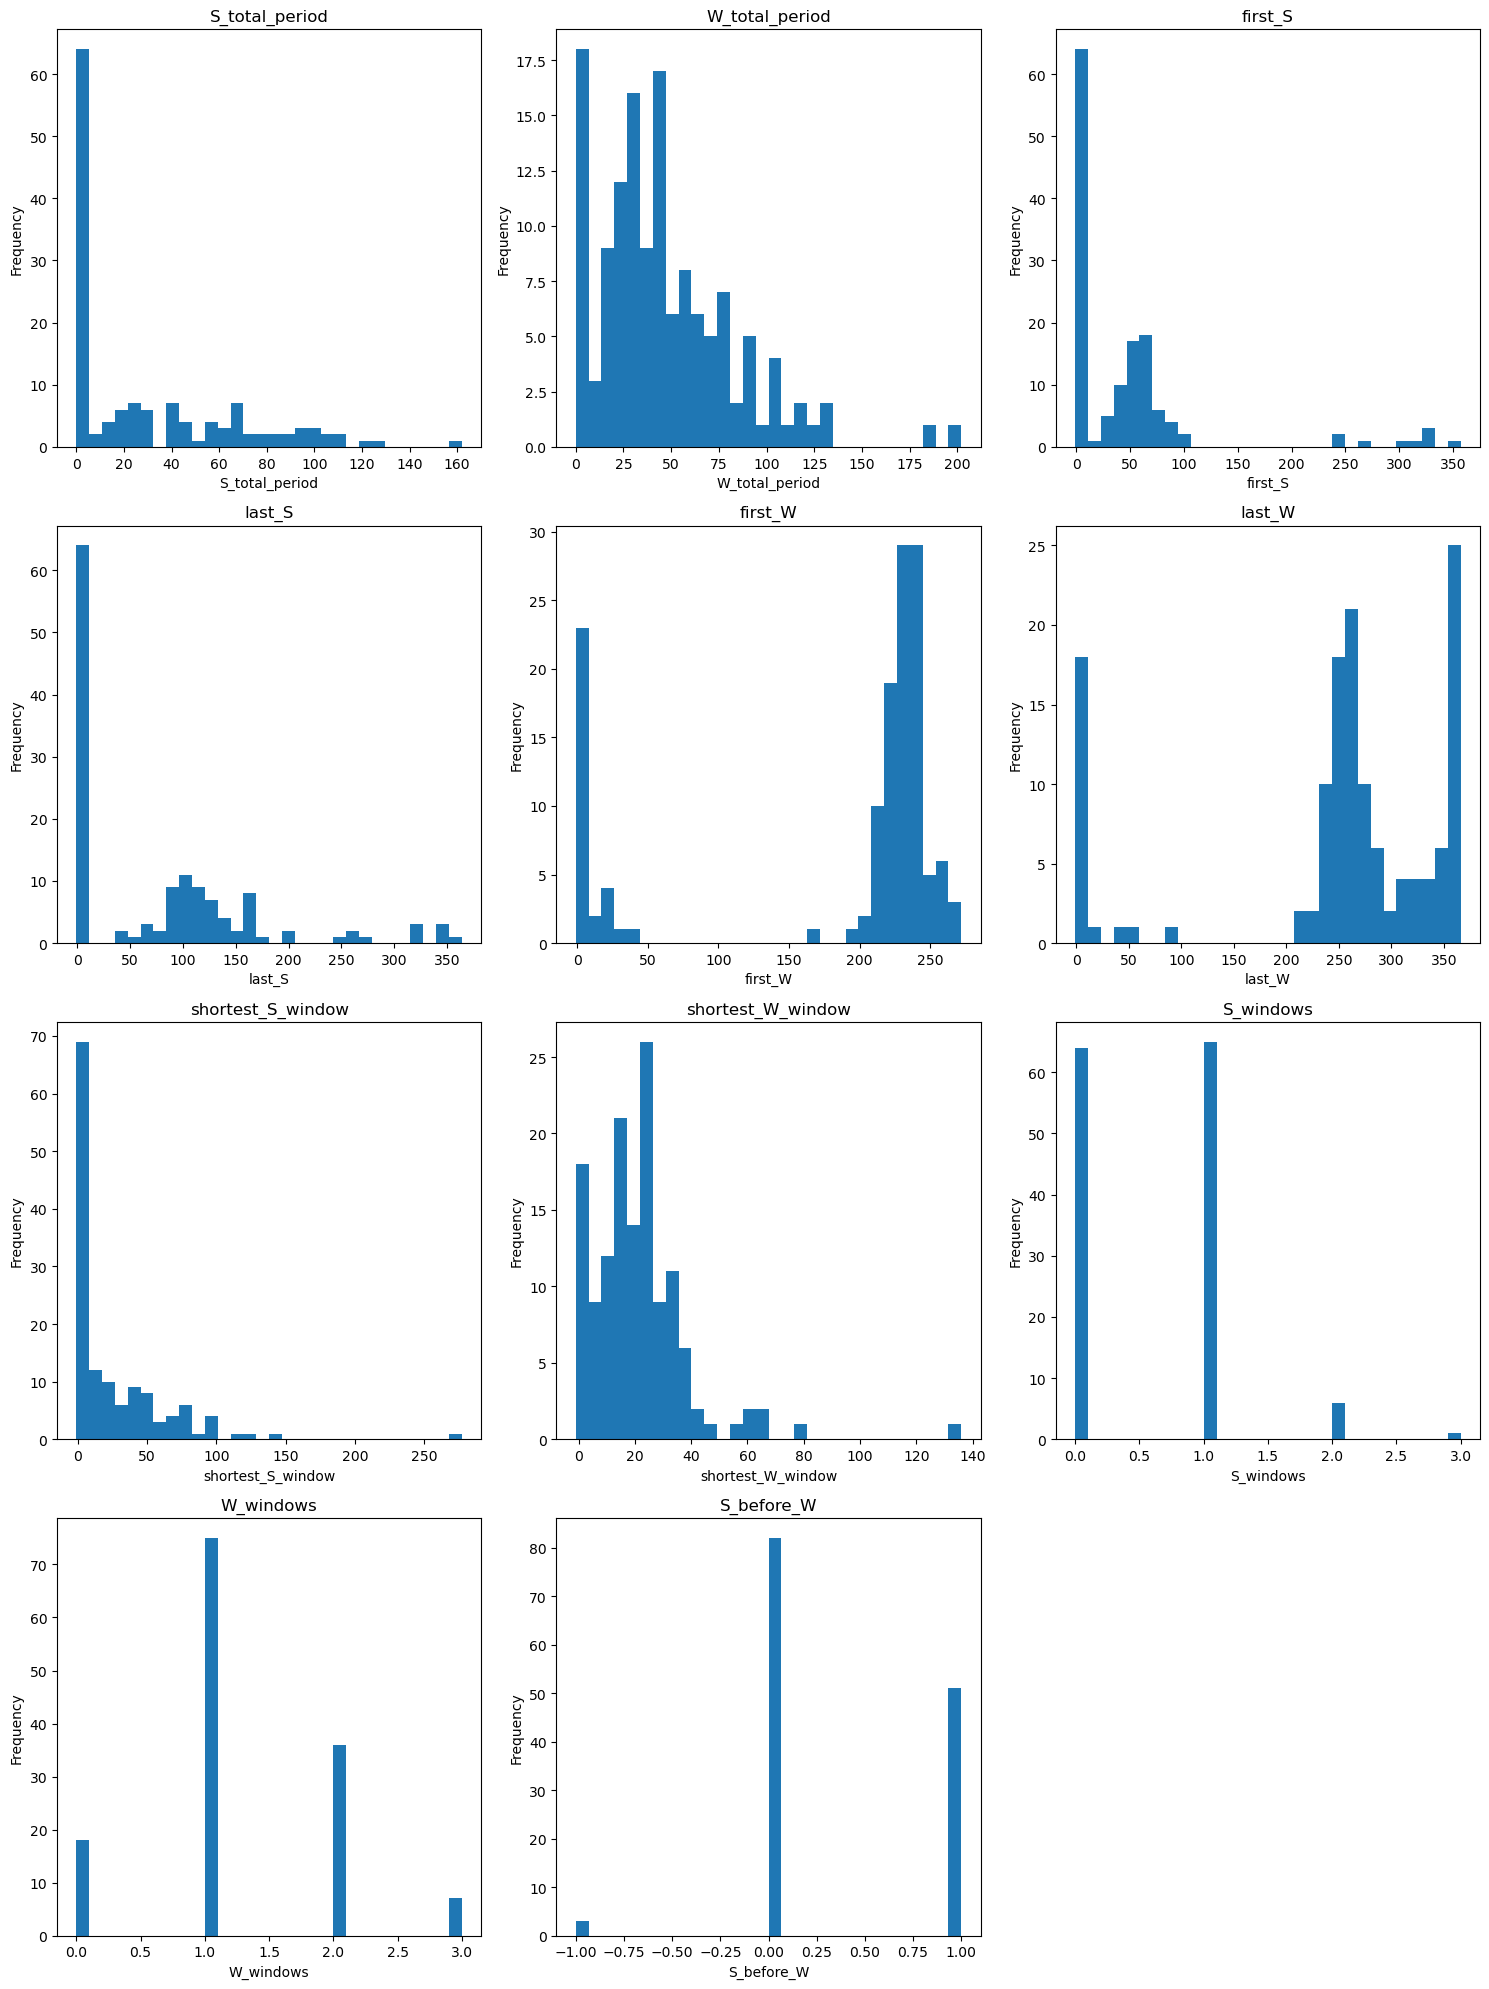

In [53]:
rows = 4
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each column (except the first one) and each axis
for i, column in enumerate(migration_overview.columns[1:]):
    # Plot histogram on the ith axis
    axes[i].hist(migration_overview[column], bins=30)
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Hide any unused axes if the number of columns is less than the number of subplots
for j in range(i+1, rows * cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

'High quality' individual would be one that has the first_S in the first half of the year and the first_W in the second half of the year. Shortest windows should be at least 14 days long. Summer migration should happen before the winter migration (if both of them are present).

In [54]:
print(f"Initially we have {len(migration_overview)} ID+year combinations.")

Initially we have 136 ID+year combinations.


In [55]:
migration_overview

,id_year,S_total_period,W_total_period,first_S,last_S,first_W,last_W,shortest_S_window,shortest_W_window,S_windows,W_windows,S_before_W
0,13015A_2001,0.0,26.0,-1.0,-1.0,217.0,238.0,-1.0,20.0,0,1,0
1,14542E_1999,11.0,30.0,246.0,254.0,222.0,245.0,7.0,23.0,1,1,0
2,14542E_2000,7.0,0.0,262.0,271.0,-1.0,-1.0,8.0,-1.0,1,0,1
3,14542E_2001,27.0,15.0,96.0,132.0,242.0,288.0,35.0,45.0,1,1,1
4,14542E_2002,0.0,34.0,-1.0,-1.0,247.0,278.0,-1.0,30.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
131,Prinzesschen_2002,74.0,110.0,50.0,125.0,9.0,346.0,74.0,9.0,1,3,0
132,Prinzesschen_2003,101.0,107.0,60.0,158.0,229.0,365.0,98.0,29.0,1,2,1
133,Prinzesschen_2004,58.0,202.0,67.0,164.0,26.0,366.0,96.0,38.0,1,3,0
134,Prinzesschen_2005,100.0,77.0,55.0,120.0,237.0,362.0,64.0,20.0,1,2,1


Separating 'high quality' individuals

In [56]:
hq_individuals = migration_overview[(migration_overview['S_before_W'] == 1) & 
                                    (migration_overview['shortest_S_window'] >= 14) & 
                                    (migration_overview['shortest_W_window'] >= 14) & 
                                    (migration_overview['first_S'] <= (366/2)) & 
                                    (migration_overview['first_W'] >= (366/2))]

print(f"After filtering we have {len(hq_individuals)} ID+year combinations.")

After filtering we have 24 ID+year combinations.


In [57]:
hq_individuals

,id_year,S_total_period,W_total_period,first_S,last_S,first_W,last_W,shortest_S_window,shortest_W_window,S_windows,W_windows,S_before_W
3,14542E_2001,27.0,15.0,96.0,132.0,242.0,288.0,35.0,45.0,1,1,1
15,14551E_1997,81.0,62.0,80.0,140.0,228.0,357.0,60.0,15.0,1,2,1
16,14551E_1998,65.0,26.0,56.0,116.0,243.0,263.0,59.0,20.0,1,1,1
18,14551E_2000,50.0,37.0,66.0,108.0,231.0,267.0,41.0,35.0,1,1,1
22,14552E_1999,70.0,78.0,49.0,166.0,233.0,365.0,53.0,23.0,2,2,1
28,14554G_2004,24.0,27.0,68.0,85.0,249.0,273.0,16.0,24.0,1,1,1
41,16896A_2002,38.0,78.0,61.0,101.0,227.0,286.0,39.0,58.0,1,1,1
42,16896A_2003,54.0,55.0,58.0,109.0,225.0,270.0,50.0,44.0,1,1,1
43,16896A_2004,83.0,16.0,37.0,130.0,203.0,244.0,92.0,40.0,1,1,1
46,16896A_2007,38.0,29.0,66.0,115.0,221.0,262.0,48.0,40.0,1,1,1


In [58]:
#hq_individuals.to_csv('data/hq_ind_overview.csv')

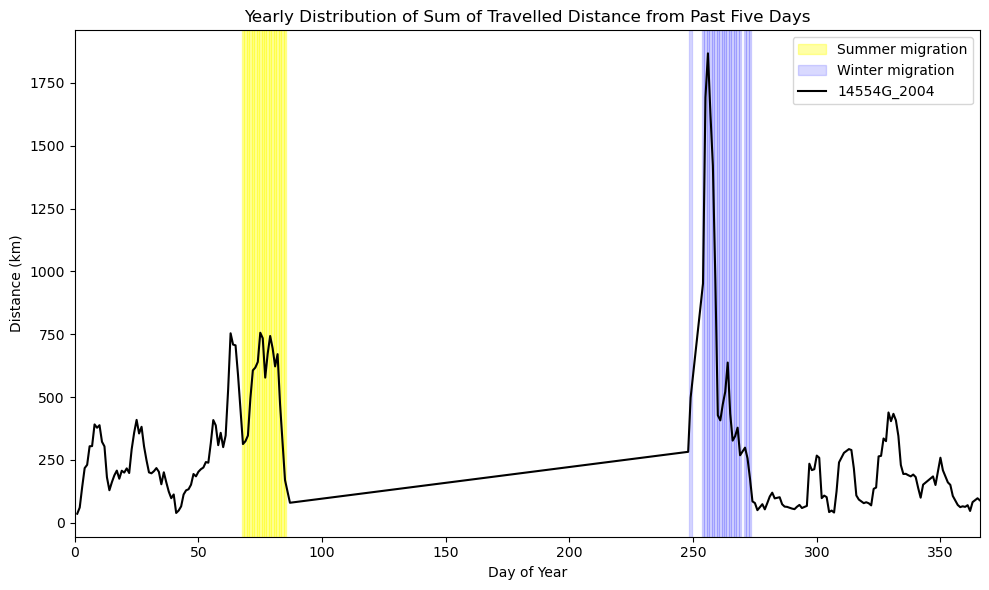

In [59]:
selected_individual = np.random.choice(hq_individuals['id_year'].unique(), 1, replace=False)

filtered_df = filled_individual_labelled_data[filled_individual_labelled_data['id_year'].isin(selected_individual)]

individual_data = filtered_df.copy()

plt.figure(figsize=(10, 6))

#Add background color for migration labels with unique labels
handles, labels = [], []
for i, row in individual_data.iterrows():
    if row['migration'] == 'W':
        plt.axvspan(row['day_of_year']-0.5, row['day_of_year']+0.5, color='blue', alpha=0.15, label='Winter migration')
        labels.append('Winter migration')
    elif row['migration'] == 'S':
        plt.axvspan(row['day_of_year']-0.5, row['day_of_year']+0.5, color='yellow', alpha=0.35, label='Summer migration')
        labels.append('Summer migration')

# Plot the rolling_sum_5_days
plt.plot(individual_data['day_of_year'], individual_data['rolling_sum_5_days'], label=selected_individual[0], c = 'black')
plt.xlim(0,366)

plt.xlabel('Day of Year')
plt.ylabel('Distance (km)')
plt.title('Yearly Distribution of Sum of Travelled Distance from Past Five Days')

#Ensure only one instance of each label is in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()

plt.show()

Extracting the year number into a separate column to get a better understanding of data distribution over years.

In [60]:
year_column = [int(ind.split("_")[1]) for ind in hq_individuals.id_year]

hq_individuals['year'] = year_column

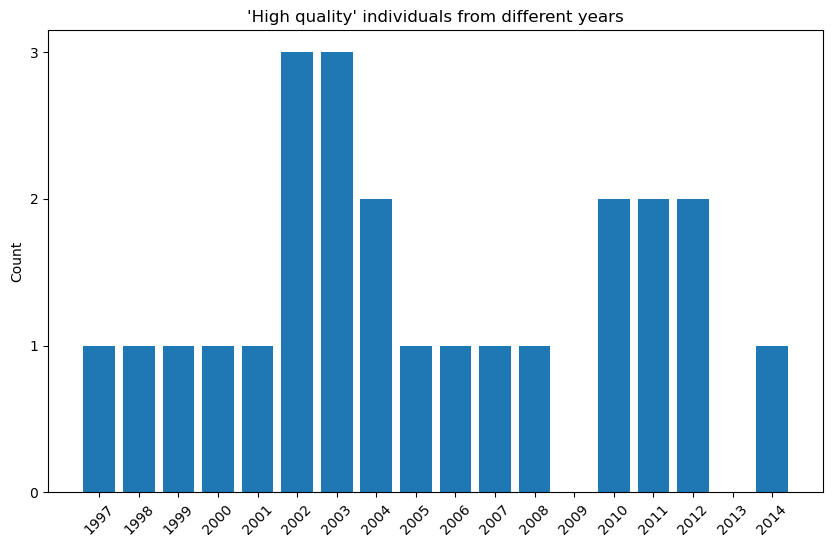

In [61]:
year_counts = hq_individuals['year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))

plt.bar(year_counts.index, year_counts.values)
plt.xticks(range(min(year_counts.index), max(year_counts.index) + 1), rotation = 45)
plt.yticks(range(min(year_counts.values) - 1, max(year_counts.values) + 1))
plt.title('\'High quality\' individuals from different years')
plt.ylabel('Count')
plt.show()

In [62]:
high_quality_birds = filled_individual_labelled_data[filled_individual_labelled_data['id_year'].isin(hq_individuals['id_year'])]

#high_quality_birds.to_csv('data/migration_hq.csv')

Also separating 'average quality' individuals that can have also either have a summer or winter migration window missing entirely

In [63]:
mq_individuals = migration_overview[(migration_overview['S_before_W'] == 1) & 
                                    ((migration_overview['shortest_S_window'] >= 14) | (migration_overview['shortest_S_window'] == -1)) & 
                                    ((migration_overview['shortest_W_window'] >= 14) | (migration_overview['shortest_W_window'] == -1)) & 
                                    ((migration_overview['first_S'] <= (366/2)) | (migration_overview['first_S'] == -1)) &
                                    ((migration_overview['first_W'] >= (366/2)) | (migration_overview['first_W'] == -1))]

print(f"After filtering we have {len(mq_individuals)} ID+year combinations.")

After filtering we have 35 ID+year combinations.


In [64]:
mq_individuals

,id_year,S_total_period,W_total_period,first_S,last_S,first_W,last_W,shortest_S_window,shortest_W_window,S_windows,W_windows,S_before_W
3,14542E_2001,27.0,15.0,96.0,132.0,242.0,288.0,35.0,45.0,1,1,1
5,14542E_2003,16.0,0.0,55.0,90.0,-1.0,-1.0,35.0,-1.0,1,0,1
15,14551E_1997,81.0,62.0,80.0,140.0,228.0,357.0,60.0,15.0,1,2,1
16,14551E_1998,65.0,26.0,56.0,116.0,243.0,263.0,59.0,20.0,1,1,1
18,14551E_2000,50.0,37.0,66.0,108.0,231.0,267.0,41.0,35.0,1,1,1
20,14552D_1997,66.0,0.0,62.0,115.0,-1.0,-1.0,52.0,-1.0,1,0,1
22,14552E_1999,70.0,78.0,49.0,166.0,233.0,365.0,53.0,23.0,2,2,1
28,14554G_2004,24.0,27.0,68.0,85.0,249.0,273.0,16.0,24.0,1,1,1
30,14555E_1995,42.0,0.0,61.0,95.0,-1.0,-1.0,33.0,-1.0,1,0,1
33,14555G_1999,104.0,0.0,48.0,326.0,-1.0,-1.0,277.0,-1.0,1,0,1


In [65]:
#mq_individuals.to_csv('data/mq_ind_overview.csv')

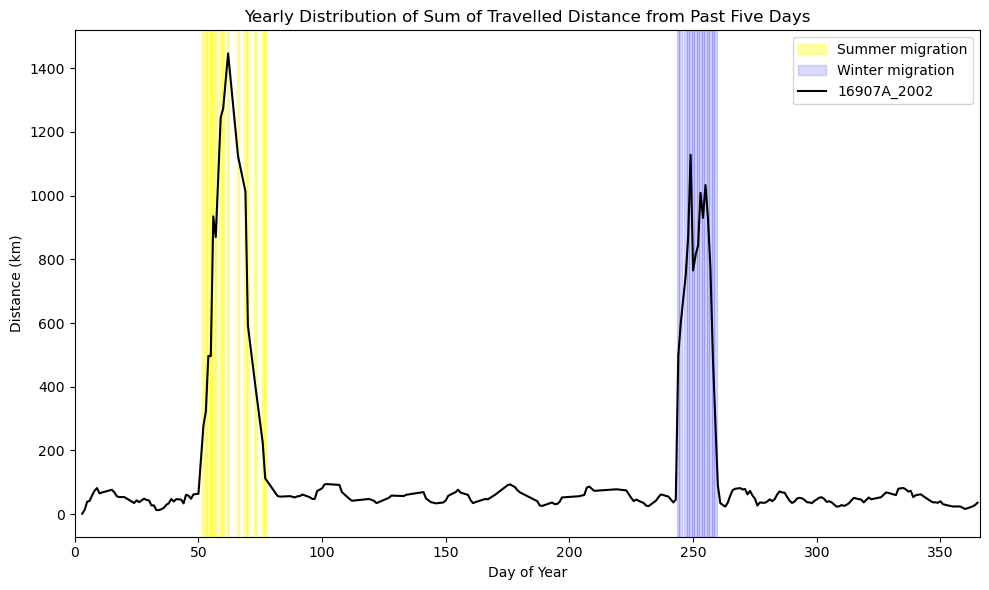

In [66]:
selected_individual = np.random.choice(mq_individuals['id_year'].unique(), 1, replace=False)

filtered_df = filled_individual_labelled_data[filled_individual_labelled_data['id_year'].isin(selected_individual)]

individual_data = filtered_df.copy()

plt.figure(figsize=(10, 6))

#Add background color for migration labels with unique labels
handles, labels = [], []
for i, row in individual_data.iterrows():
    if row['migration'] == 'W':
        plt.axvspan(row['day_of_year']-0.5, row['day_of_year']+0.5, color='blue', alpha=0.15, label='Winter migration')
        labels.append('Winter migration')
    elif row['migration'] == 'S':
        plt.axvspan(row['day_of_year']-0.5, row['day_of_year']+0.5, color='yellow', alpha=0.35, label='Summer migration')
        labels.append('Summer migration')

# Plot the rolling_sum_5_days
plt.plot(individual_data['day_of_year'], individual_data['rolling_sum_5_days'], label=selected_individual[0], c = 'black')
plt.xlim(0,366)

plt.xlabel('Day of Year')
plt.ylabel('Distance (km)')
plt.title('Yearly Distribution of Sum of Travelled Distance from Past Five Days')

#Ensure only one instance of each label is in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()

plt.show()

In [67]:
year_column = [int(ind.split("_")[1]) for ind in mq_individuals.id_year]

mq_individuals['year'] = year_column

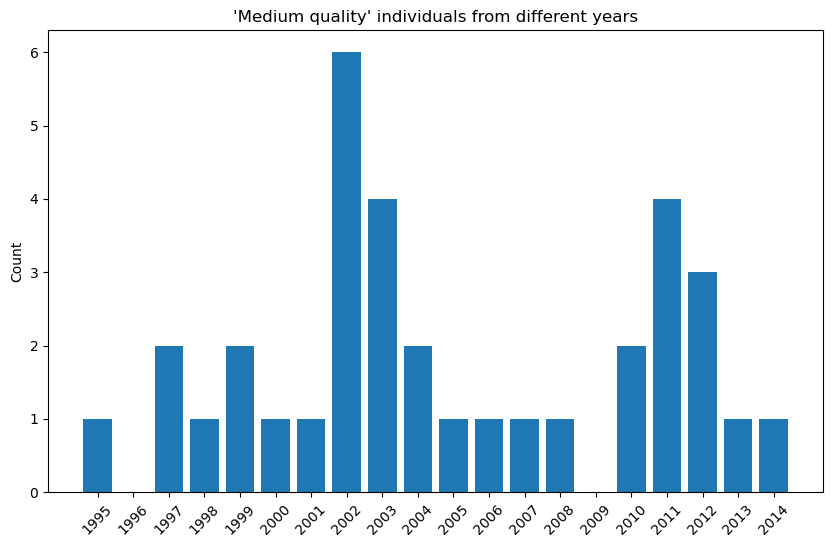

In [68]:
year_counts = mq_individuals['year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))

plt.bar(year_counts.index, year_counts.values)
plt.xticks(range(min(year_counts.index), max(year_counts.index) + 1), rotation = 45)
plt.yticks(range(min(year_counts.values) - 1, max(year_counts.values) + 1))
plt.title('\'Medium quality\' individuals from different years')
plt.ylabel('Count')
plt.show()

In [69]:
medium_quality_birds = filled_individual_labelled_data[filled_individual_labelled_data['id_year'].isin(mq_individuals['id_year'])]

#medium_quality_birds.to_csv('data/migration_mq.csv')